# **Open-world: Binary Classification**
In this notebook, we conduct Open-world experiments using the Random Forest model selected during the previous model selection process. Here, we perform **binary classification** to determine whether a web traffic trace belongs to a monitored website.

All instances of monitored websites (positive samples) are assigned the label '1', while all instances of unmonitored websites (negative samples) are assigned the label '-1'. The model is trained and tested under this binary classification setup.


## 1. Data Preprocessing

In [ ]:
# 1) Load Monitored Dataset
# Convert specific features of the monitored dataset 'mon_standart.pkl' into arrays.

import pickle

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading monitored datafile...")
with open("/mon_standard.pkl", 'rb') as fi: # Path to mon_standard.pkl in Colab
    data = pickle.load(fi)

X1 = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information
y = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(1)
size = len(y)

print(f'Total samples: {size}') # Output: 19000

Loading monitored datafile...
Total samples: 19000


In [ ]:
# 2) Load UnMonitored Dataset
print("Loading unmonitored datafile...")
with open("unmon_standard10_3000.pkl", 'rb') as fi: # Path to unmon_standard10_3000.pkl in Colab
    unmon_data = pickle.load(fi)

# Process unmonitored data
X1_unmon, X2_unmon, y_unmon = [], [], []
for sample in unmon_data:
    size_seq = []
    time_seq = []
    for c in sample:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512)
    X1_unmon.append(time_seq)
    X2_unmon.append(size_seq)
    y_unmon.append(-1)  # Label unmonitored data as -1

print(f"Total unmonitored samples: {len(y_unmon)}")  # Output: 3000

Loading unmonitored datafile...
Total unmonitored samples: 3000


## 2. Feature Extraction

In [ ]:
# Feature extraction

import pandas as pd
import numpy as np

# A function to calculate the number of incoming/outgoing packets for the first 30 packets in each row
def count_in_out_first_30(X2):
    n_in_first = [] # Number of incoming packets for the first 30 packets
    n_out_first = [] # # Number of outgoing packets for the first 30 packets

    for packets in X2:
        # Calculate n_in_first and n_out_first for the first 30 packets
        n_in_f = sum(1 for packet in packets[:30] if packet > 0)
        n_out_f = sum(1 for packet in packets[:30] if packet < 0)

        # Append each result to the respective lists
        n_in_first.append(n_in_f)
        n_out_first.append(n_out_f)

    return n_in_first, n_out_first

# A function to calculate basic features
def compute_features(X2, X1):
    n_pkt = []  # Total number of packets
    n_in = []  # Number of incoming packets
    n_out = []  # Number of outgoing packets
    r_in = []  # Number of incoming packets as a fraction of the total number
    r_out = []  # Number of outgoing packets as a fraction of the total number
    n_pkt_persec = []  # Packets per second

    for i in range(0, len(X2)):
        cnt_in = 0
        for j in range(0, len(X2[i])):
            if X2[i][j] < 0:
                cnt_in += 1
        n_pkt.append(len(X2[i]))
        n_in.append(cnt_in)
        n_out.append(len(X2[i]) - cnt_in)
        r_in.append(cnt_in / len(X2[i]) if len(X2[i]) > 0 else 0)
        r_out.append(1 - (cnt_in / len(X2[i])) if len(X2[i]) > 0 else 0)
        t = X1[i][-1] - X1[i][0] if len(X1[i]) > 1 else 1
        n_pkt_persec.append(n_pkt[i] / t if t > 0 else 0)

    n_in_first, n_out_first = count_in_out_first_30(X2)

    # Create a dataframe
    df_mon = pd.DataFrame({
        'n_pkt': n_pkt,
        'n_in': n_in,
        'n_out': n_out,
        'r_in': r_in,
        'r_out': r_out,
        'n_in_first': n_in_first,
        'n_out_first': n_out_first,
        'n_pkt_persec': n_pkt_persec
    })

    return df_mon

# A function to calculate the standard deviation of outgoing packets
def outgoing_packet_std(X2):
    std_list = []

    for packets in X2:
        outgoing_indices = [i for i, packet in enumerate(packets) if packet < 0]

        if len(outgoing_indices) == 0:
            std_list.append(0)
        else:
            std_list.append(np.std(outgoing_indices))

    return std_list

# A function to calculate the number of packets in the last 5 seconds
def count_packets_last_5_seconds(X1):
    n_last_5s = []
    for timestamps in X1:
        if not timestamps:
            n_last_5s.append(0)
        else:
            end_time = timestamps[-1]
            start_time = end_time - 5
            n_last_5s.append(sum(1 for t in timestamps if t > start_time))
    return n_last_5s

# A function to calculate newly added features
def add_new_features(df_mon, X2, X1):
    sum_alt_concentration = [sum(abs(packet) for packet in packets) for packets in X2]
    df_mon['sum_alt_concentration'] = sum_alt_concentration # Sum of absolute packet size

    alt_pkt_persec = [
        sum(abs(packet) for packet in packets) / (X1[i][-1] - X1[i][0]) if len(packets) > 1 and X1[i][-1] > X1[i][0] else 0 for i, packets in enumerate(X2)
    ]
    df_mon['alt_pkt_persec'] = alt_pkt_persec # Average absolute packet size per second

    df_mon['std_ordering'] = [pd.Series(packets).std() for packets in X2] # Standard Deviation of Packet Sizes

    outgoing_std = outgoing_packet_std(X2)
    df_mon['std_dev of outgoing'] = outgoing_std # Standard Derivation of Outgoing Packets

    cumulative_pkt_size = [sum(map(abs, packets)) for packets in X2]
    df_mon['cumulative_pkt_size'] = cumulative_pkt_size # Cumulative packet Size

    avg_burst_interval = []
    for i in range(len(X1)):
        burst_intervals = [X1[i][j+1] - X1[i][j] for j in range(len(X1[i])-1) if abs(X2[i][j]) > 0]
        avg_burst_interval.append(sum(burst_intervals) / len(burst_intervals) if burst_intervals else 0)
    df_mon['avg_burst_interval'] = avg_burst_interval # Average of Burst Interval

    std_time_interval = [np.std([X1[i][k+1] - X1[i][k] for k in range(len(X1[i])-1)]) if len(X1[i]) > 1 else 0 for i in range(len(X1))]
    df_mon['std_time_interval'] = std_time_interval # Standard Deviation of Time Intervals

    sum_alternate_pkt_per_sec = []
    for packets in X2:
        count = 0
        for i in range(1, len(packets)):
            if (packets[i] > 0 and packets[i-1] < 0) or (packets[i] < 0 and packets[i-1] > 0):
                count += 1
        sum_alternate_pkt_per_sec.append(count)

    df_mon['sum_alternate_pkt_per_sec'] = sum_alternate_pkt_per_sec # Number of packets changing direction per second in each sample

    df_mon['#of_packets_in_last_5_seconds'] = count_packets_last_5_seconds(X1) # Number of packets during the last 5 seconds

    return df_mon

In [ ]:
# Generate features for monitored data
df_mon = compute_features(X2, X1)
df_mon = add_new_features(df_mon, X2, X1)

# Generate features for unmonitored data
df_unmon = compute_features(X2_unmon, X1_unmon)
df_unmon = add_new_features(df_unmon, X2_unmon, X1_unmon)

# Pearson correlation coefficient between packet size and timestamps (mon)
df_mon['size_time_corr'] = [
    pd.Series(packets).corr(pd.Series(times)) if len(packets) > 1 else np.nan
    for packets, times in zip(X2, X1)
]

# Pearson correlation coefficient between packet size and timestamps (unmon)
df_unmon['size_time_corr'] = [
    pd.Series(packets).corr(pd.Series(times)) if len(packets) > 1 else np.nan
    for packets, times in zip(X2_unmon, X1_unmon)
]

# Add label column for monitored data
df_mon['label'] = y

# Add label column for unmonitored data
df_unmon['label'] = y_unmon

In [ ]:
# Check the Monitored DataFrame created with the features
print("mon")
df_mon.head()

mon


,n_pkt,n_in,n_out,r_in,r_out,n_in_first,n_out_first,n_pkt_persec,sum_alt_concentration,alt_pkt_persec,std_ordering,std_dev of outgoing,cumulative_pkt_size,avg_burst_interval,std_time_interval,sum_alternate_pkt_per_sec,#of_packets_in_last_5_seconds,size_time_corr,label
0,1421,1300,121,0.914849,0.085151,9,21,140.138067,727552,71750.690335,285.905893,398.486335,727552,0.007141,0.041168,155,179,0.068924,1
1,518,438,80,0.845560,0.154440,8,22,50.984252,265216,26103.937008,370.400747,150.591146,265216,0.019652,0.163930,93,236,-0.104867,1
2,1358,1240,118,0.913108,0.086892,7,23,122.232223,695296,62582.898290,288.543964,381.878642,695296,0.008187,0.066661,151,303,0.081140,1
3,1446,1324,122,0.915629,0.084371,9,21,108.233533,740352,55415.568862,284.712015,406.205288,740352,0.009246,0.047809,159,161,0.090254,1
4,1406,1291,115,0.918208,0.081792,8,22,132.142857,719872,67657.142857,280.725055,395.028889,719872,0.007573,0.038760,157,167,0.090400,1


In [ ]:
# Check the UnMonitored DataFrame created with the features
print("unmon")
df_unmon.head()

unmon


,n_pkt,n_in,n_out,r_in,r_out,n_in_first,n_out_first,n_pkt_persec,sum_alt_concentration,alt_pkt_persec,std_ordering,std_dev of outgoing,cumulative_pkt_size,avg_burst_interval,std_time_interval,sum_alternate_pkt_per_sec,#of_packets_in_last_5_seconds,size_time_corr,label
0,130,101,29,0.776923,0.223077,13,17,23.381295,66560,11971.223022,427.950079,36.304696,66560,0.043101,0.105741,34,126,-0.390973,-1
1,9927,9189,738,0.925657,0.074343,12,18,835.606061,5082624,427830.303030,268.637178,2845.096286,5082624,0.001197,0.019357,774,8824,-0.110602,-1
2,359,285,74,0.793872,0.206128,13,17,20.157215,183808,10320.494104,414.810278,100.730751,183808,0.049749,0.249810,75,50,-0.117080,-1
3,9948,9407,541,0.945617,0.054383,9,21,1084.841876,5093376,555439.040349,232.225664,2855.784563,5093376,0.000922,0.017914,731,9922,-0.045137,-1
4,2508,2215,293,0.883174,0.116826,3,27,46.799776,1284096,23961.485352,328.987729,716.374241,1284096,0.021376,0.263498,339,4,0.062707,-1


## 3. Binary Classification

In [ ]:
!pip install psutil

import psutil

# Check RAM
ram = psutil.virtual_memory()
print(f"Total: {ram.total / (1024 ** 3):.2f} GB")
print(f"Used: {ram.used / (1024 ** 3):.2f} GB")
print(f"Available: {ram.available / (1024 ** 3):.2f} GB")

# Check CPU
print(f"CPU Cores: {psutil.cpu_count(logical=False)} physical cores")
print(f"Logical CPUs: {psutil.cpu_count(logical=True)} logical CPUs")

# Check disk space
partitions = psutil.disk_partitions()
for partition in partitions:
    usage = psutil.disk_usage(partition.mountpoint)
    print(f"Device: {partition.device}")
    print(f"Total: {usage.total / (1024 ** 3):.2f} GB")
    print(f"Used: {usage.used / (1024 ** 3):.2f} GB")
    print(f"Free: {usage.free / (1024 ** 3):.2f} GB")
    print(f"Percent Used: {usage.percent}%")

Used: 12.98 GB
Available: 2.70 GB
CPU Cores: 14 physical cores
Logical CPUs: 20 logical CPUs

Device: C:\
Total: 476.18 GB
Used: 115.41 GB
Free: 360.77 GB
Percent Used: 24.2%


In [ ]:
import os
import psutil
import platform
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Print dataset information
def dataset_info(X, y):
    print(f"- Number of Samples: {X.shape[0]}")
    print(f"- Number of Features: {X.shape[1]}")
    print(f"- Target Classes: {len(set(y))}")
    print(f"- Approximate Memory Usage: {X.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")
    print()

# Print system information
def system_info():
    print("=== System Information ===")
    print(f"- OS: {platform.system()} {platform.version()}")
    print(f"- CPU: {platform.processor()}")
    print(f"- Total RAM: {round(psutil.virtual_memory().total / (1024 ** 3), 2)} GB")
    print(f"- Available RAM: {round(psutil.virtual_memory().available / (1024 ** 3), 2)} GB")
    print()

# Print model parameter information
def model_info(model):
    print("=== Model Parameters ===")
    for param, value in model.get_params().items():
        print(f"- {param}: {value}")
    print()

# Measure resource usage
def measure_resource_usage(func):
    def wrapper(*args, **kwargs):
        process = psutil.Process(os.getpid())
        cpu_before = psutil.cpu_percent(interval=None)
        mem_before = process.memory_info().rss / (1024 ** 2)

        result = func(*args, **kwargs)

        cpu_after = psutil.cpu_percent(interval=None)
        mem_after = process.memory_info().rss / (1024 ** 2)
        print("\n=== Resource Usage ===")
        print(f"- CPU Usage: {cpu_after - cpu_before:.2f}%")
        print(f"- Peak RAM Usage: {mem_after - mem_before:.2f} MB")
        return result

    return wrapper

In [ ]:
# Train-test split (monitored)
X = df_mon[df_mon.columns[:-1]]
y = df_mon['label']

print("===  Monitored Dataset Information ===")
dataset_info(X, y)

# Train-test split (unmonitored)
X_unmon = df_unmon[df_unmon.columns[:-1]]
y_unmon = df_unmon['label']

print("===  Unmonitored Dataset Information ===")
dataset_info(X_unmon, y)
system_info()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X_unmon_train, X_unmon_test, y_unmon_train, y_unmon_test = train_test_split(X_unmon, y_unmon, test_size=0.2, random_state=2)

# Combine data for classification
X_train = np.vstack((X_train, X_unmon_train))
y_train = np.hstack((y_train, y_unmon_train))
X_test = np.vstack((X_test, X_unmon_test))
y_test = np.hstack((y_test, y_unmon_test))

print("===  Monitored and Unmonitored Dataset Information ===")
print(f"- Training Set: {X_train.shape[0]} samples, {X_train.shape[1]} features.")
print(f"- Test Set: {X_test.shape[0]} samples, {X_test.shape[1]} features.")
print()

===  Monitored Dataset Information ===
- Number of Samples: 19000
- Number of Features: 18
- Target Classes: 1
- Approximate Memory Usage: 2.61 MB

===  Unmonitored Dataset Information ===
- Number of Samples: 3000
- Number of Features: 18
- Target Classes: 1
- Approximate Memory Usage: 0.41 MB

=== System Information ===
- OS: Windows 10.0.22621
- CPU: Intel64 Family 6 Model 154 Stepping 3, GenuineIntel
- Total RAM: 15.68 GB
- Available RAM: 2.69 GB

===  Monitored and Unmonitored Dataset Information ===
- Training Set: 17600 samples, 18 features.
- Test Set: 4400 samples, 18 features.



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

@measure_resource_usage
def train_model(X_train, y_train, X_test, y_test):
    # RandomForest Model Tuning - Finding Optimal Parameters
    # Set parameter grid
    param_grid = {
        'n_estimators': [100, 500, 1000],
        'max_depth': [None, 10, 20, 50],
        'min_samples_split': [2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2'],
        'criterion': ['gini', 'entropy']
    }

    # Initialize RandomForest model
    rf = RandomForestClassifier(random_state=2)

    # Hyperparameter optimization using GridSearch
    grid_search = GridSearchCV(
        estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy'
    )
    grid_search.fit(X_train, y_train)

    # Perform Binary Classification
    # Predict and evaluate using the optimal model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Print model information
    print("\n=== Best Model Parameters ===")
    model_info(best_model)

    # Evaluate the model's performance
    print("\n=== Model Performance ===")
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy on test dataset: {}".format(accuracy))
    precision = precision_score(y_test, y_pred, average='micro')
    print("Precision on test dataset: {}".format(precision))
    print(classification_report(y_test, y_pred, labels=list(range(95))))

    print("\nClassification Report:\n", classification_report(y_test, y_pred, labels=list(range(95))))

    return best_model, y_pred, accuracy, precision

best_model, y_pred, accuracy, precision = train_model(X_train, y_train, X_test, y_test)


=== Best Model Parameters ===
=== Model Parameters ===
- bootstrap: True
- ccp_alpha: 0.0
- class_weight: None
- criterion: entropy
- max_depth: None
- max_features: auto
- max_leaf_nodes: None
- max_samples: None
- min_impurity_decrease: 0.0
- min_samples_leaf: 1
- min_samples_split: 2
- min_weight_fraction_leaf: 0.0
- n_estimators: 500
- n_jobs: None
- oob_score: False
- random_state: 2
- verbose: 0
- warm_start: False


=== Model Performance ===
Accuracy on test dataset: 0.9043181818181818
Precision on test dataset: 0.9043181818181818
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.91      0.99      0.95      3800
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_cla

Result: Best Model's Performance
- Accuracy on test dataset: **0.9043181818181818**
- Precision on test dataset: 0.9043181818181818

## 4. Result

In [ ]:
# 1) Number of Samples Classified (monitored / unmonitored)

import pandas as pd

# Create DataFrame using y_pred, y_test
results = pd.DataFrame({
    "Index": range(1, len(y_test) + 1),
    "True Label": y_test,
    "Predicted Label": y_pred
})

# Number of samples classified as 1 and -1
num_positive = (y_pred == 1).sum()  # Number of data classified as 1
num_negative = (y_pred == -1).sum()  # Number of data classified as -1

print(f"Number of samples classified as 1: {num_positive}")
print(f"Number of samples classified as -1: {num_negative}")

results

Number of samples classified as 1: 4159
Number of samples classified as -1: 241


,Index,True Label,Predicted Label
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1
...,...,...,...
4395,4396,-1,1
4396,4397,-1,1
4397,4398,-1,1
4398,4399,-1,1


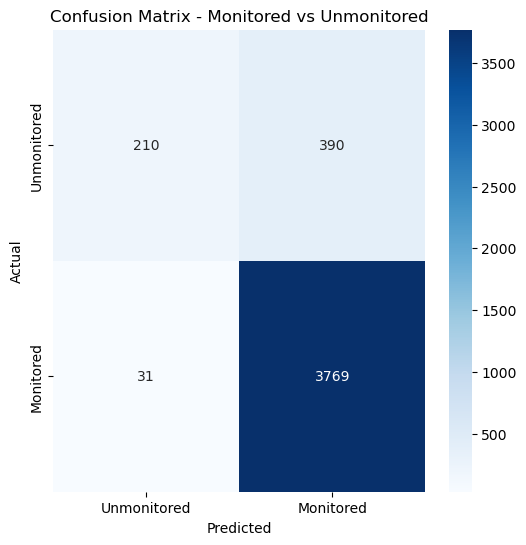

In [ ]:
# 2) Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualization
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Unmonitored", "Monitored"], yticklabels=["Unmonitored", "Monitored"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Monitored vs Unmonitored')
plt.show()

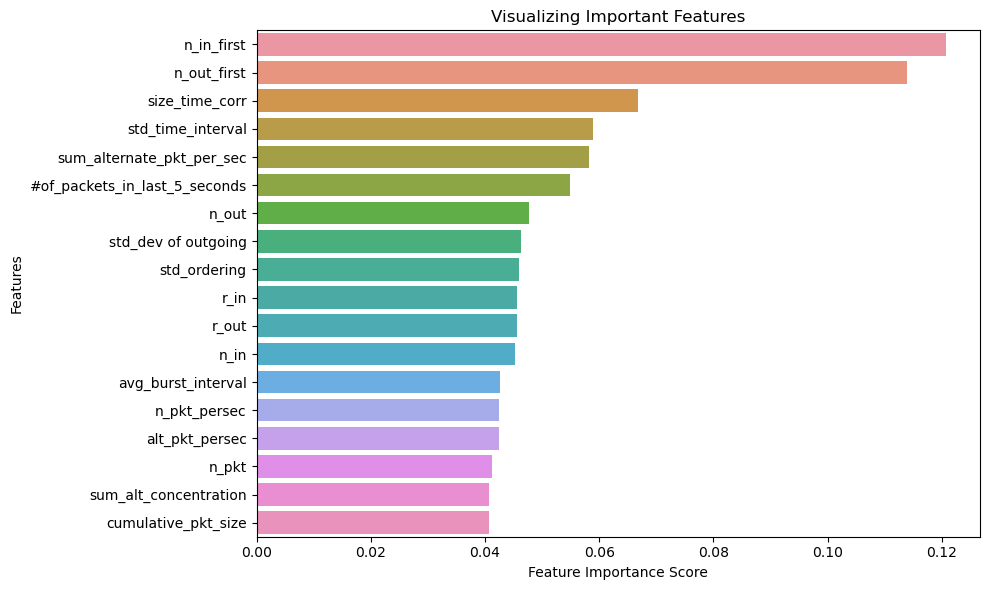

In [ ]:
# 3) Feature Importance

# Calculate feature importance and sort it in descending order
feature_imp = pd.Series(best_model.feature_importances_, index=df_mon.columns[:-1]).sort_values(ascending=False)

# Create a bar plot to visualize feature importance
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

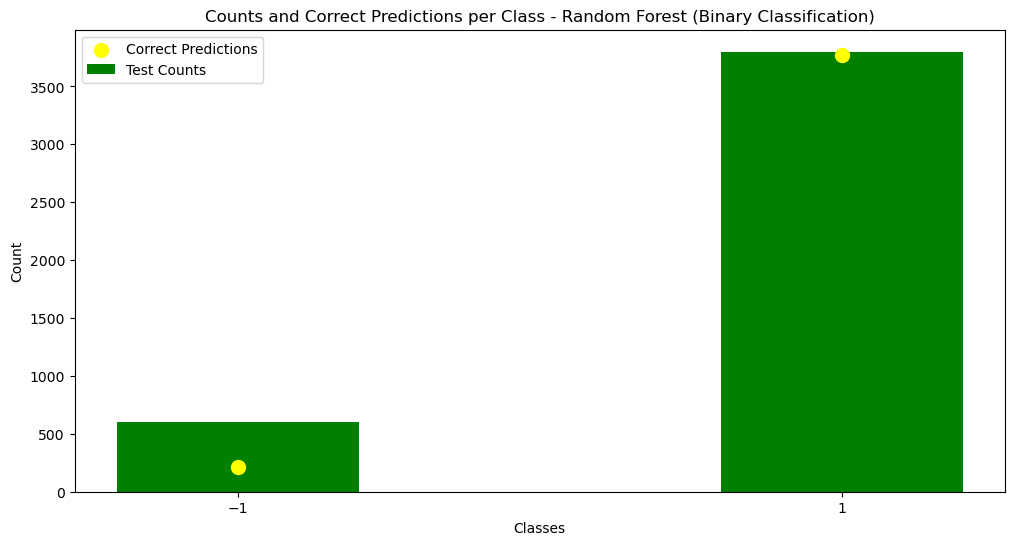

In [ ]:
# 4) Counts and Correct Predictions per Class

from collections import Counter

# Calculate the number of test data for each class
test_counts = Counter(y_test)

# Calculate the number of correctly predicted data for each class
correct_predictions = (y_test == y_pred)
correct_counts = Counter(y_test[correct_predictions])

# Set the two classes: -1 and 1
classes = np.array([-1, 1])

# Plot test data counts as a bar plot
plt.figure(figsize=(12, 6))
plt.bar(classes, [test_counts[i] for i in classes], color='green', label='Test Counts')

# Plot correctly predicted data as yellow dots
plt.scatter(classes, [correct_counts[i] if i in correct_counts else 0 for i in classes],
            color='yellow', label='Correct Predictions', s=100)
plt.xticks(classes)

plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Counts and Correct Predictions per Class - Random Forest (Binary Classification)')
plt.legend()

plt.show()

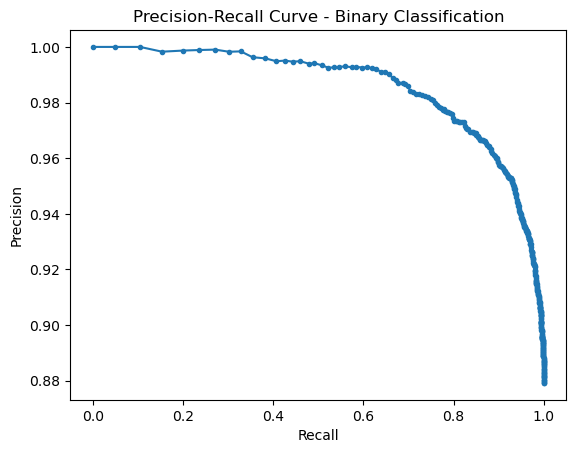

In [ ]:
# 5) Precision-Recall Curve

from sklearn.metrics import precision_recall_curve

# Calculate precision and recall values using the best_model
precision, recall, _ = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:, 1])

# Plot the Precision-Recall curve
plt.plot(recall, precision, marker='.')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Binary Classification')
plt.show()

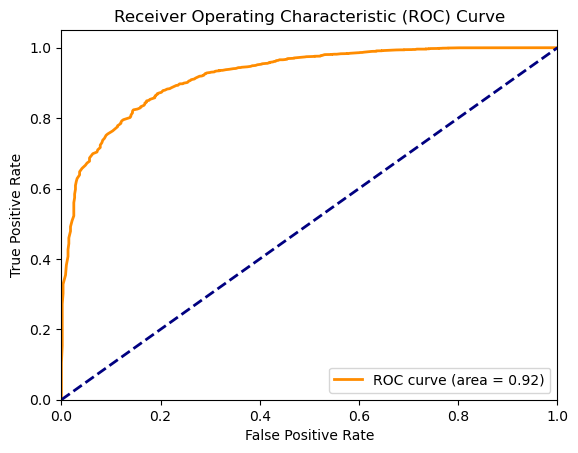

In [ ]:
# 6) ROC Curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute false positive rate (fpr) and true positive rate (tpr) using the best_model
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

# Plot a diagonal line for random chance
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()